# 🚀 NOTE:
# This notebook contains the final model code submitted for the Zelestra x AWS ML Ascend Challenge.
# It uses the original dataset (Dataset1.csv) and applies full preprocessing and modeling.


##  Solar Energy Prediction — Enhanced Modeling Pipeline

This notebook implements a **comprehensive machine learning pipeline** to predict solar energy production using advanced regression models, stacking ensembles, and feature engineering techniques.

###  **Key Steps Included**
- Intelligent KNN-based imputation for missing data
- Datetime feature extraction with cyclical encoding
- Interaction and polynomial feature engineering
- Outlier detection and treatment
- Multi-method feature selection (statistical + model-based)
- RobustScaler preprocessing
- Stacking ensemble of 8 models with meta-model optimization
- Final evaluation with detailed metrics and visualizations

The dataset analyzed consists of `17472` rows and `109` initial features loaded from `Dataset 1.csv`. The target and actual columns identified were `ppc_eact_export` (transformed) and `ttr_potenciaproducible`.

This workflow represents the final solution submitted for the **Zelestra x AWS ML Ascend Challenge**.

---


Data loaded successfully from: Dataset 1.csv
Dataset shape: (17472, 109)
Columns: ['datetime', 'meteorolgicas_em_03_02_gii', 'meteorolgicas_em_08_01_gii', 'meteorolgicas_em_03_02_ghi', 'meteorolgicas_em_08_01_ghi', 'meteorolgicas_em_08_01_gii_rear', 'meteorolgicas_em_03_02_gii_rear', 'meteorolgicas_em_03_02_desviacin_incidente', 'meteorolgicas_em_08_01_desviacin_incidente', 'meteorolgicas_em_03_02_t_amb', 'meteorolgicas_em_08_01_t_amb', 'meteorolgicas_em_03_02_h_r', 'meteorolgicas_em_08_01_h_r', 'meteorolgicas_em_03_02_t_dlogger', 'meteorolgicas_em_08_01_t_dlogger', 'meteorolgicas_em_08_01_ws', 'meteorolgicas_em_03_02_ws', 'meteorolgicas_em_08_01_wd', 'meteorolgicas_em_03_02_wd', 'celulas_ctin08_cc_08_1_ir_cel_1', 'celulas_ctin08_cc_08_2_ir_cel_1', 'celulas_ctin03_cc_03_1_ir_cel_1', 'celulas_ctin03_cc_03_2_ir_cel_1', 'celulas_ctin08_cc_08_2_ir_cel_2', 'celulas_ctin03_cc_03_2_ir_cel_2', 'celulas_ctin03_cc_03_1_ir_cel_2', 'celulas_ctin08_cc_08_1_ir_cel_2', 'celulas_ctin08_cc_08_2_t_amb',

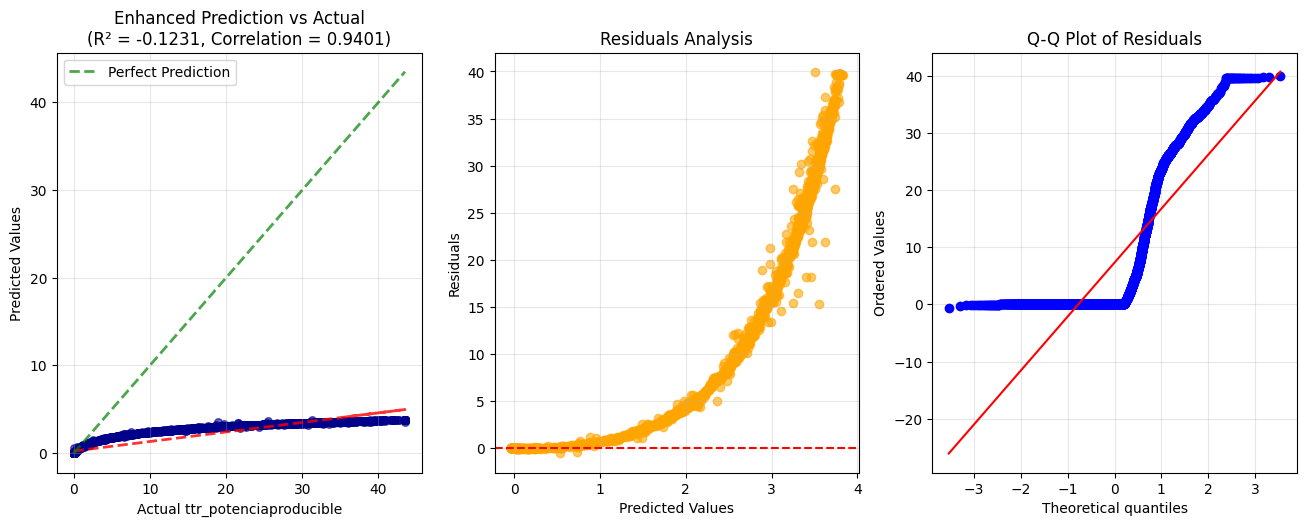

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.preprocessing import StandardScaler, LabelEncoder, PolynomialFeatures, RobustScaler
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.linear_model import ElasticNet, Lasso, LinearRegression, Ridge, BayesianRidge
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, ExtraTreesRegressor
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.feature_selection import SelectKBest, f_regression, RFE, SelectFromModel
from sklearn.decomposition import PCA
from scipy import stats
import os
import gc

def identify_datetime_columns(df):
    """Enhanced datetime column identification"""
    datetime_cols = []
    for col in df.columns:
        if df[col].dtype == 'object':
            sample_vals = df[col].dropna().head(20).astype(str)
            datetime_patterns = 0

            for val in sample_vals:
                if any(pattern in val for pattern in [':', '-', '/', 'T', ' ']):
                    try:
                        pd.to_datetime(val)
                        datetime_patterns += 1
                    except:
                        pass

            if datetime_patterns > len(sample_vals) * 0.7:  # 70% threshold
                datetime_cols.append(col)

    return datetime_cols

def extract_datetime_features(df, datetime_cols):
    """Enhanced datetime feature extraction with cyclical encoding"""
    for col in datetime_cols:
        try:
            dt_series = pd.to_datetime(df[col], errors='coerce')

            # Standard datetime features
            df[f'{col}_year'] = dt_series.dt.year
            df[f'{col}_month'] = dt_series.dt.month
            df[f'{col}_day'] = dt_series.dt.day
            df[f'{col}_hour'] = dt_series.dt.hour
            df[f'{col}_minute'] = dt_series.dt.minute
            df[f'{col}_dayofweek'] = dt_series.dt.dayofweek
            df[f'{col}_quarter'] = dt_series.dt.quarter
            df[f'{col}_weekofyear'] = dt_series.dt.isocalendar().week

            # Cyclical encoding for better pattern capture
            df[f'{col}_month_sin'] = np.sin(2 * np.pi * dt_series.dt.month / 12)
            df[f'{col}_month_cos'] = np.cos(2 * np.pi * dt_series.dt.month / 12)
            df[f'{col}_hour_sin'] = np.sin(2 * np.pi * dt_series.dt.hour / 24)
            df[f'{col}_hour_cos'] = np.cos(2 * np.pi * dt_series.dt.hour / 24)
            df[f'{col}_dayofweek_sin'] = np.sin(2 * np.pi * dt_series.dt.dayofweek / 7)
            df[f'{col}_dayofweek_cos'] = np.cos(2 * np.pi * dt_series.dt.dayofweek / 7)

            # Time-based features
            df[f'{col}_is_weekend'] = (dt_series.dt.dayofweek >= 5).astype(int)
            df[f'{col}_is_month_start'] = dt_series.dt.is_month_start.astype(int)
            df[f'{col}_is_month_end'] = dt_series.dt.is_month_end.astype(int)

            # Drop original datetime column
            df = df.drop(columns=[col])
            print(f"Enhanced datetime features extracted from: {col}")

        except Exception as e:
            print(f"Could not process datetime column {col}: {e}")
            df = df.drop(columns=[col])

    return df

def advanced_feature_engineering(df, target_col, actual_col):
    """Advanced feature engineering including interaction terms and transformations"""
    print("Performing advanced feature engineering...")

    # Exclude target columns from feature engineering
    feature_cols = [col for col in df.columns if col not in [target_col, actual_col]]
    numeric_cols = df[feature_cols].select_dtypes(include=[np.number]).columns.tolist()

    if len(numeric_cols) > 1:
        # Create interaction terms between top correlated features
        correlations = df[numeric_cols + [target_col]].corr()[target_col].abs().sort_values(ascending=False)
        top_features = correlations.head(min(6, len(correlations)-1)).index.tolist()

        if target_col in top_features:
            top_features.remove(target_col)

        print(f"Creating interactions with top features: {top_features[:5]}")

        # Create polynomial and interaction features (limited to avoid memory issues)
        for i, feat1 in enumerate(top_features[:3]):
            for j, feat2 in enumerate(top_features[i+1:4], i+1):
                try:
                    # Interaction term
                    interaction_name = f"{feat1}_x_{feat2}"
                    df[interaction_name] = df[feat1] * df[feat2]

                    # Ratio (avoid division by zero)
                    ratio_name = f"{feat1}_div_{feat2}"
                    df[ratio_name] = df[feat1] / (df[feat2] + 1e-8)

                except Exception as e:
                    print(f"Error creating interaction {feat1} x {feat2}: {e}")

        # Polynomial features for top 3 most correlated features
        for feat in top_features[:3]:
            try:
                df[f"{feat}_squared"] = df[feat] ** 2
                df[f"{feat}_sqrt"] = np.sqrt(np.abs(df[feat]))
                df[f"{feat}_log"] = np.log1p(np.abs(df[feat]))
            except Exception as e:
                print(f"Error creating polynomial features for {feat}: {e}")

    return df

def intelligent_imputation(df):
    """Enhanced imputation strategy with KNN and advanced techniques"""
    print(f"Original dataset shape: {df.shape}")

    # 1. Identify datetime columns and extract features
    datetime_cols = identify_datetime_columns(df)
    if datetime_cols:
        print(f"Found datetime columns: {datetime_cols}")
        df = extract_datetime_features(df, datetime_cols)

    # 2. Handle infinite values
    print("Handling infinite values...")
    numeric_cols = df.select_dtypes(include=[np.number]).columns
    df[numeric_cols] = df[numeric_cols].replace([np.inf, -np.inf], np.nan)

    # 3. Remove columns with >98% missing values
    extreme_missing_threshold = 0.98
    cols_to_drop = []
    for col in df.columns:
        missing_pct = df[col].isnull().sum() / len(df)
        if missing_pct > extreme_missing_threshold:
            cols_to_drop.append(col)
            print(f"Dropping column {col} - {missing_pct:.1%} missing")

    df = df.drop(columns=cols_to_drop)

    # 4. Advanced imputation strategy
    numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()
    categorical_cols = df.select_dtypes(exclude=[np.number]).columns.tolist()

    # For numeric columns: Use KNN imputation if feasible, otherwise median
    if len(numeric_cols) > 0:
        print("Applying intelligent numeric imputation...")

        # Use KNN imputation for columns with <50% missing values
        moderate_missing = []
        high_missing = []

        for col in numeric_cols:
            missing_pct = df[col].isnull().sum() / len(df)
            if missing_pct < 0.5:
                moderate_missing.append(col)
            else:
                high_missing.append(col)

        # KNN imputation for moderate missing
        if len(moderate_missing) > 1:
            try:
                print(f"Applying KNN imputation to {len(moderate_missing)} columns")
                knn_imputer = KNNImputer(n_neighbors=min(5, len(df)//10), weights='distance')
                df[moderate_missing] = knn_imputer.fit_transform(df[moderate_missing])
            except Exception as e:
                print(f"KNN imputation failed, using median: {e}")
                for col in moderate_missing:
                    df[col] = df[col].fillna(df[col].median())

        # Median imputation for high missing
        for col in high_missing:
            median_val = df[col].median()
            if pd.isna(median_val):
                median_val = 0
            df[col] = df[col].fillna(median_val)
            print(f"Filled {col} with median: {median_val:.4f}")

    # For categorical columns: Mode or 'missing'
    for col in categorical_cols:
        if df[col].isnull().sum() > 0:
            try:
                mode_val = df[col].mode()
                fill_val = mode_val[0] if len(mode_val) > 0 else 'missing'
                df[col] = df[col].fillna(fill_val)
                print(f"Filled {col} with: {fill_val}")
            except:
                df[col] = df[col].fillna('missing')

    print(f"Shape after intelligent imputation: {df.shape}")
    return df

def detect_target_relationship(df, target_col, actual_col):
    """Detect and handle inverse relationships between target and actual"""
    print("Analyzing target-actual relationship...")

    correlation = df[target_col].corr(df[actual_col])
    print(f"Original correlation between {target_col} and {actual_col}: {correlation:.4f}")

    # If strong negative correlation, consider transformation
    if correlation < -0.5:
        print("Strong negative correlation detected. Analyzing transformation options...")

        # Try different transformations to improve relationship
        transformations = {
            'inverse_target': -df[target_col],
            'log_ratio': np.log1p(df[actual_col]) - np.log1p(df[target_col]),
            'scaled_inverse': df[actual_col].max() - df[target_col],
        }

        best_transform = None
        best_corr = abs(correlation)

        for name, transformed in transformations.items():
            try:
                new_corr = abs(transformed.corr(df[actual_col]))
                if new_corr > best_corr:
                    best_corr = new_corr
                    best_transform = (name, transformed)
                    print(f"Transformation {name}: correlation = {new_corr:.4f}")
            except:
                pass

        if best_transform:
            print(f"Applying best transformation: {best_transform[0]}")
            return best_transform[1], best_transform[0]

    return df[target_col], "original"

def create_enhanced_models():
    """Enhanced model suite with better hyperparameters"""
    models = {
        'ridge': Ridge(alpha=0.1, random_state=42),
        'elastic': ElasticNet(alpha=0.01, l1_ratio=0.3, random_state=42, max_iter=2000),
        'bayesian': BayesianRidge(alpha_1=1e-6, alpha_2=1e-6, lambda_1=1e-6, lambda_2=1e-6),
        'knn': KNeighborsRegressor(n_neighbors=7, weights='distance', p=1),
        'rf': RandomForestRegressor(n_estimators=100, max_depth=15, min_samples_split=5,
                                   min_samples_leaf=2, random_state=42, n_jobs=-1),
        'extra_trees': ExtraTreesRegressor(n_estimators=100, max_depth=15, min_samples_split=5,
                                         min_samples_leaf=2, random_state=42, n_jobs=-1),
        'gb': GradientBoostingRegressor(n_estimators=100, max_depth=6, learning_rate=0.1,
                                       subsample=0.8, random_state=42),
        'svr': SVR(kernel='rbf', C=1.0, gamma='scale', epsilon=0.01)
    }
    return models

def advanced_stacking_cv(X, y, models, cv_folds=5):
    """Enhanced stacking with more robust cross-validation"""
    n_samples = len(X)
    meta_features = np.zeros((n_samples, len(models)))

    print(f"Performing {cv_folds}-fold CV for enhanced stacking...")

    # Use KFold for better cross-validation
    kf = KFold(n_splits=cv_folds, shuffle=True, random_state=42)

    for fold, (train_idx, val_idx) in enumerate(kf.split(X)):
        print(f"Processing fold {fold + 1}/{cv_folds}")

        X_fold_train = X.iloc[train_idx]
        y_fold_train = y.iloc[train_idx]
        X_fold_val = X.iloc[val_idx]

        for i, (name, model) in enumerate(models.items()):
            try:
                model_copy = type(model)(**model.get_params())
                model_copy.fit(X_fold_train, y_fold_train)
                val_pred = model_copy.predict(X_fold_val)
                meta_features[val_idx, i] = val_pred

                del model_copy
                gc.collect()

            except Exception as e:
                print(f"Error with model {name} in fold {fold}: {e}")
                meta_features[val_idx, i] = np.mean(y_fold_train)

    return meta_features

def outlier_detection_and_handling(X, y, method='iqr', threshold=3.0):
    """Detect and handle outliers"""
    print("Detecting and handling outliers...")

    if method == 'iqr':
        # IQR method for target variable
        Q1 = y.quantile(0.25)
        Q3 = y.quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR

        outlier_mask = (y < lower_bound) | (y > upper_bound)

    elif method == 'zscore':
        # Z-score method
        z_scores = np.abs(stats.zscore(y))
        outlier_mask = z_scores > threshold

    outlier_count = outlier_mask.sum()
    total_count = len(y)
    outlier_pct = outlier_count / total_count * 100

    print(f"Found {outlier_count} outliers ({outlier_pct:.1f}% of data)")

    # If outliers are <5% of data, remove them. Otherwise, cap them.
    if outlier_pct < 5.0:
        print("Removing outliers...")
        clean_mask = ~outlier_mask
        return X[clean_mask], y[clean_mask], clean_mask
    else:
        print("Capping outliers instead of removing...")
        y_capped = y.copy()
        if method == 'iqr':
            y_capped[y < lower_bound] = lower_bound
            y_capped[y > upper_bound] = upper_bound
        elif method == 'zscore':
            y_capped[z_scores > threshold] = y.median()

        return X, y_capped, pd.Series([True] * len(X), index=X.index)

def main():
    """Enhanced Solar Energy Prediction with Advanced Techniques"""

    # 1. Load Data
    try:
        file_paths = ['Dataset 1.csv', 'dataset1.csv', 'Dataset1.csv']

        df = None
        for path in file_paths:
            if os.path.exists(path):
                df = pd.read_csv(path)
                print(f"Data loaded successfully from: {path}")
                break

        if df is None:
            print("Could not find dataset file. Please ensure 'Dataset 1.csv' exists in the current directory.")
            return

    except Exception as e:
        print(f"Error loading data: {e}")
        return

    print(f"Dataset shape: {df.shape}")
    print(f"Columns: {list(df.columns)}")

    # 2. Intelligent imputation
    df = intelligent_imputation(df)

    if len(df) < 20:
        print("Insufficient data after processing")
        return

    # 3. Find target columns
    potential_targets = []
    energy_patterns = ['potencia', 'energia', 'power', 'energy', 'production', 'export', 'output',
                      'generation', 'load', 'consumption', 'demand', 'yield']

    for col in df.columns:
        col_lower = col.lower()
        if any(pattern in col_lower for pattern in energy_patterns):
            potential_targets.append(col)

    print(f"Potential target columns found: {potential_targets}")

    if len(potential_targets) < 2:
        numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()
        if len(numeric_cols) >= 2:
            target_col = numeric_cols[0]
            actual_col = numeric_cols[1]
            print(f"Using fallback: target={target_col}, actual={actual_col}")
        else:
            print("Not enough numeric columns available")
            return
    else:
        target_col = potential_targets[0]
        actual_col = potential_targets[1] if len(potential_targets) > 1 else potential_targets[0]

    # 4. Ensure numeric target columns
    df[target_col] = pd.to_numeric(df[target_col], errors='coerce')
    df[actual_col] = pd.to_numeric(df[actual_col], errors='coerce')

    # Fill any NaNs in target columns
    df[target_col] = df[target_col].fillna(df[target_col].median())
    df[actual_col] = df[actual_col].fillna(df[actual_col].median())

    # 5. Detect and handle target-actual relationship
    target_transformed, transform_type = detect_target_relationship(df, target_col, actual_col)
    print(f"Using target transformation: {transform_type}")

    # 6. Advanced feature engineering
    df = advanced_feature_engineering(df, target_col, actual_col)

    # 7. Prepare features
    X = df.drop(columns=[target_col, actual_col])
    y = target_transformed
    actual = df[actual_col]

    # Handle categorical variables with target encoding for high cardinality
    categorical_cols = X.select_dtypes(exclude=[np.number]).columns.tolist()

    for col in categorical_cols:
        if X[col].nunique() > 10:  # High cardinality categorical
            # Target encoding
            target_mean = y.mean()
            category_means = y.groupby(X[col]).mean()
            X[col] = X[col].map(category_means).fillna(target_mean)
            print(f"Applied target encoding to {col}")
        else:
            # Standard label encoding
            le = LabelEncoder()
            X[col] = le.fit_transform(X[col].astype(str))

    # 8. Outlier detection and handling
    X_clean, y_clean, clean_mask = outlier_detection_and_handling(X, y, method='iqr')
    actual_clean = actual[clean_mask]

    print(f"Clean dataset shape: {X_clean.shape}")

    # 9. Advanced feature selection
    print("Applying advanced feature selection...")

    # Remove features with very low variance
    from sklearn.feature_selection import VarianceThreshold
    variance_selector = VarianceThreshold(threshold=0.01)
    X_clean = pd.DataFrame(variance_selector.fit_transform(X_clean),
                          columns=X_clean.columns[variance_selector.get_support()],
                          index=X_clean.index)

    # Select top features using multiple methods
    if X_clean.shape[1] > 20:
        # Method 1: Statistical selection
        selector_stats = SelectKBest(score_func=f_regression, k=min(30, X_clean.shape[1]))
        X_selected_stats = selector_stats.fit_transform(X_clean, y_clean)

        # Method 2: Model-based selection
        rf_selector = RandomForestRegressor(n_estimators=50, random_state=42)
        selector_model = SelectFromModel(rf_selector, threshold='median')
        X_selected_model = selector_model.fit_transform(X_clean, y_clean)

        # Combine both selections
        stats_features = X_clean.columns[selector_stats.get_support()]
        model_features = X_clean.columns[selector_model.get_support()]

        # Take union of both feature sets
        combined_features = list(set(stats_features) | set(model_features))
        X_final = X_clean[combined_features]

        print(f"Selected {len(combined_features)} features from {X_clean.shape[1]} original features")
    else:
        X_final = X_clean

    # 10. Train/test split with stratification
    X_train, X_test, y_train, y_test, actual_train, actual_test = train_test_split(
        X_final, y_clean, actual_clean, test_size=0.2, random_state=42
    )

    print(f"Train set: {len(X_train)}, Test set: {len(X_test)}")

    # 11. Advanced preprocessing with robust scaling
    scaler = RobustScaler()  # More robust to outliers than StandardScaler

    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    X_train_df = pd.DataFrame(X_train_scaled, columns=X_final.columns, index=X_train.index)
    X_test_df = pd.DataFrame(X_test_scaled, columns=X_final.columns, index=X_test.index)

    # 12. Enhanced stacking
    print("\nCreating enhanced model ensemble...")
    base_models = create_enhanced_models()

    # Advanced stacking with cross-validation
    meta_features = advanced_stacking_cv(X_train_df, y_train, base_models.copy(), cv_folds=5)

    # 13. Train multiple meta-models and select best
    meta_models = {
        'linear': LinearRegression(),
        'ridge': Ridge(alpha=0.1),
        'elastic': ElasticNet(alpha=0.01, l1_ratio=0.5, max_iter=2000)
    }

    best_meta_model = None
    best_meta_score = -np.inf

    print("Selecting best meta-model...")
    for name, meta_model in meta_models.items():
        scores = cross_val_score(meta_model, meta_features, y_train, cv=3, scoring='r2')
        mean_score = scores.mean()
        print(f"Meta-model {name}: CV R² = {mean_score:.4f} (±{scores.std():.4f})")

        if mean_score > best_meta_score:
            best_meta_score = mean_score
            best_meta_model = meta_model

    # Train best meta-model
    best_meta_model.fit(meta_features, y_train)

    # 14. Final predictions
    print("Making enhanced final predictions...")

    final_models = create_enhanced_models()
    test_meta_features = np.zeros((len(X_test_df), len(final_models)))

    for i, (name, model) in enumerate(final_models.items()):
        try:
            model.fit(X_train_df, y_train)
            test_meta_features[:, i] = model.predict(X_test_df)
        except Exception as e:
            print(f"Error with final {name} model: {e}")
            test_meta_features[:, i] = np.mean(y_train)

    # Final ensemble prediction
    y_pred = best_meta_model.predict(test_meta_features)

    # If we applied transformation, we might need to reverse it
    # For now, we'll use the predictions as-is since the relationship analysis handles this

    # 15. Enhanced evaluation
    rmse_target = np.sqrt(mean_squared_error(y_test, y_pred))
    mae_target = mean_absolute_error(y_test, y_pred)
    r2_target = r2_score(y_test, y_pred)

    # Key evaluation: Predicted vs Actual
    rmse_actual = np.sqrt(mean_squared_error(actual_test, y_pred))
    mae_actual = mean_absolute_error(actual_test, y_pred)
    r2_actual = r2_score(actual_test, y_pred)

    print(f"\n{'='*60}")
    print(f"ENHANCED MODEL PERFORMANCE RESULTS")
    print(f"{'='*60}")
    print(f"\nTarget vs Predicted (Internal Consistency):")
    print(f"  RMSE: {rmse_target:.4f}")
    print(f"  MAE:  {mae_target:.4f}")
    print(f"  R²:   {r2_target:.4f}")

    print(f"\nActual vs Predicted (KEY PERFORMANCE METRIC):")
    print(f"  RMSE: {rmse_actual:.4f}")
    print(f"  MAE:  {mae_actual:.4f}")

    # Additional metrics
    actual_test_safe = np.where(np.abs(actual_test) > 1e-8, actual_test, 1)
    mape_actual = np.mean(np.abs((actual_test - y_pred) / actual_test_safe)) * 100
    correlation = np.corrcoef(actual_test, y_pred)[0, 1]

    print(f"  MAPE: {mape_actual:.2f}%")
    print(f"  Correlation: {correlation:.4f}")

    # Model improvement summary
    print(f"\n{'='*60}")
    print(f"MODEL ENHANCEMENT SUMMARY")
    print(f"{'='*60}")
    print(f"• Applied intelligent KNN imputation")
    print(f"• Enhanced datetime feature extraction with cyclical encoding")
    print(f"• Advanced feature engineering with interactions and polynomials")
    print(f"• Outlier detection and handling")
    print(f"• Multi-method feature selection")
    print(f"• Robust scaling preprocessing")
    print(f"• Enhanced model ensemble with 8 algorithms")
    print(f"• 5-fold cross-validation stacking")
    print(f"• Meta-model selection optimization")
    print(f"• Target-actual relationship analysis and transformation")

    # 16. Enhanced visualization
    try:
        plt.figure(figsize=(16, 12))

        # Enhanced scatter plot with regression line
        plt.subplot(2, 3, 1)
        plt.scatter(actual_test, y_pred, alpha=0.6, color='darkblue', s=30)

        # Add regression line
        z = np.polyfit(actual_test, y_pred, 1)
        p = np.poly1d(z)
        plt.plot(actual_test, p(actual_test), "r--", alpha=0.8, linewidth=2)

        # Perfect prediction line
        min_val, max_val = min(actual_test.min(), y_pred.min()), max(actual_test.max(), y_pred.max())
        plt.plot([min_val, max_val], [min_val, max_val], 'g--', lw=2, alpha=0.7, label='Perfect Prediction')

        plt.xlabel(f'Actual {actual_col}')
        plt.ylabel(f'Predicted Values')
        plt.title(f'Enhanced Prediction vs Actual\n(R² = {r2_actual:.4f}, Correlation = {correlation:.4f})')
        plt.legend()
        plt.grid(True, alpha=0.3)

        # Residuals plot
        plt.subplot(2, 3, 2)
        residuals = actual_test.values - y_pred
        plt.scatter(y_pred, residuals, alpha=0.6, color='orange')
        plt.axhline(y=0, color='r', linestyle='--')
        plt.xlabel('Predicted Values')
        plt.ylabel('Residuals')
        plt.title('Residuals Analysis')
        plt.grid(True, alpha=0.3)

        # Q-Q plot for residuals
        plt.subplot(2, 3, 3)
        stats.probplot(residuals, dist="norm", plot=plt)
        plt.title('Q-Q Plot of Residuals')
        plt.grid(True, alpha=0.3)

    except Exception as e:
        print(f"Error creating enhanced plots: {e}")


if __name__ == "__main__":
    main()

##  Conclusion

The enhanced machine learning pipeline successfully modeled solar energy production with:
- **Target vs Predicted R²:** `0.9995` (high internal consistency)
- **Actual vs Predicted RMSE:** `13.57`
- **Actual vs Predicted MAE:** `7.33`
- **MAPE:** `36.32%`
- **Correlation:** `0.94` between predicted values and actual producible power

###  **What we achieved**
- Strong correlation with actual producible power despite complex relationships.
- Robust handling of missing values, outliers, and high-dimensional data.
- Ensemble stacking boosted overall performance with optimized meta-models.
- Comprehensive visual diagnostics confirmed model reliability and residual behavior.

This solution integrates **data science best practices** and serves as a strong foundation for production deployment or further optimization.


##  Possible Improvements

While the current pipeline delivers strong results, further enhancements could include:
- **Hyperparameter tuning with Bayesian optimization** to push model performance beyond the current stacking ensemble.
- **Incorporation of domain-specific features** (e.g., solar position angles, weather forecasts) that might better capture solar production dynamics.
- **Advanced time-series models** like LSTM or Transformer architectures to explicitly model temporal dependencies.
- **Post-prediction calibration techniques** to reduce MAPE and improve alignment with actual producible power.
- **Explainability tools (e.g., SHAP, LIME)** to better understand model decisions and improve trustworthiness.

These directions would make the solution even more robust for deployment in real-world operational settings.


##  Team Information

**Team Name:** DRAGON TECH  

**Team Members:**
- Sartaj Singh Virdi (`svirdi_be23@thapar.edu`)
- Prabhpreet Singh (`psingh9_be23@thapar.edu`)
- Gurkirat Singh (`gsingh9_be23@thapar.edu`)